# Customer Segmentation and Analysis Using KMeans and Gaussian Mixture Models (GMM)

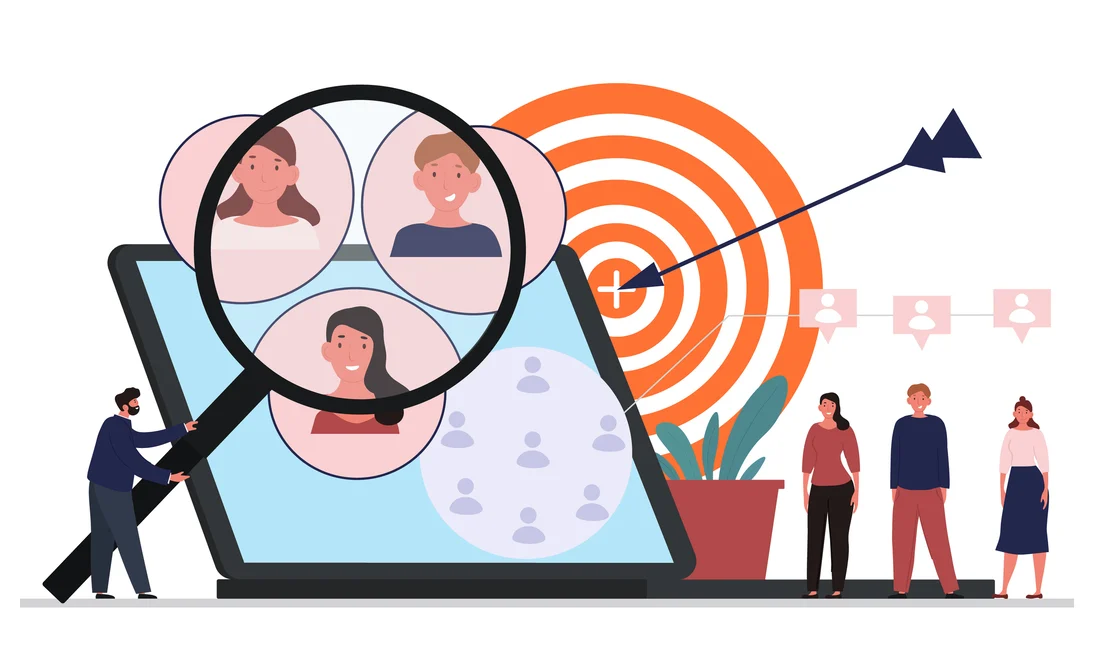

## Mount Google Drive
This cell mounts your Google Drive in the Colab environment, so you can access files stored there, such as your Kaggle API key.

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Up Kaggle API Credentials
This cell copies your Kaggle API key (kaggle.json) from Google Drive to the appropriate directory in Colab and sets the correct permissions, so you can use Kaggle commands to download datasets.

In [38]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Rowaina/APIs/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Download and Unzip Dataset from Kaggle
Here you download the Credit Card Customers dataset from Kaggle into the ./data folder and then unzip it so you can use the CSV files inside.

In [39]:
!kaggle datasets download -d arjunbhasin2013/ccdata -p ./data
!unzip ./data/ccdata.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
License(s): CC0-1.0
ccdata.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./data/ccdata.zip
replace ./data/CC GENERAL.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/CC GENERAL.csv   


## Import Required Libraries

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

## Load Dataset and Initial Exploration
Load the dataset from CSV file. Then, show the first few rows, dataset shape (rows and columns), column names, data types, statistical summary, and count missing values for each column. This helps to understand the data structure and quality.

In [41]:
df = pd.read_csv('./data/CC GENERAL.csv')
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [42]:
df.shape

(8950, 18)

In [43]:
df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [45]:
df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

In [46]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

## Visualize Distributions of Numerical Columns
Plot histograms with KDE (Kernel Density Estimate) for all numerical features. This helps to visualize the data distribution and detect skewness or outliers.

In [47]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


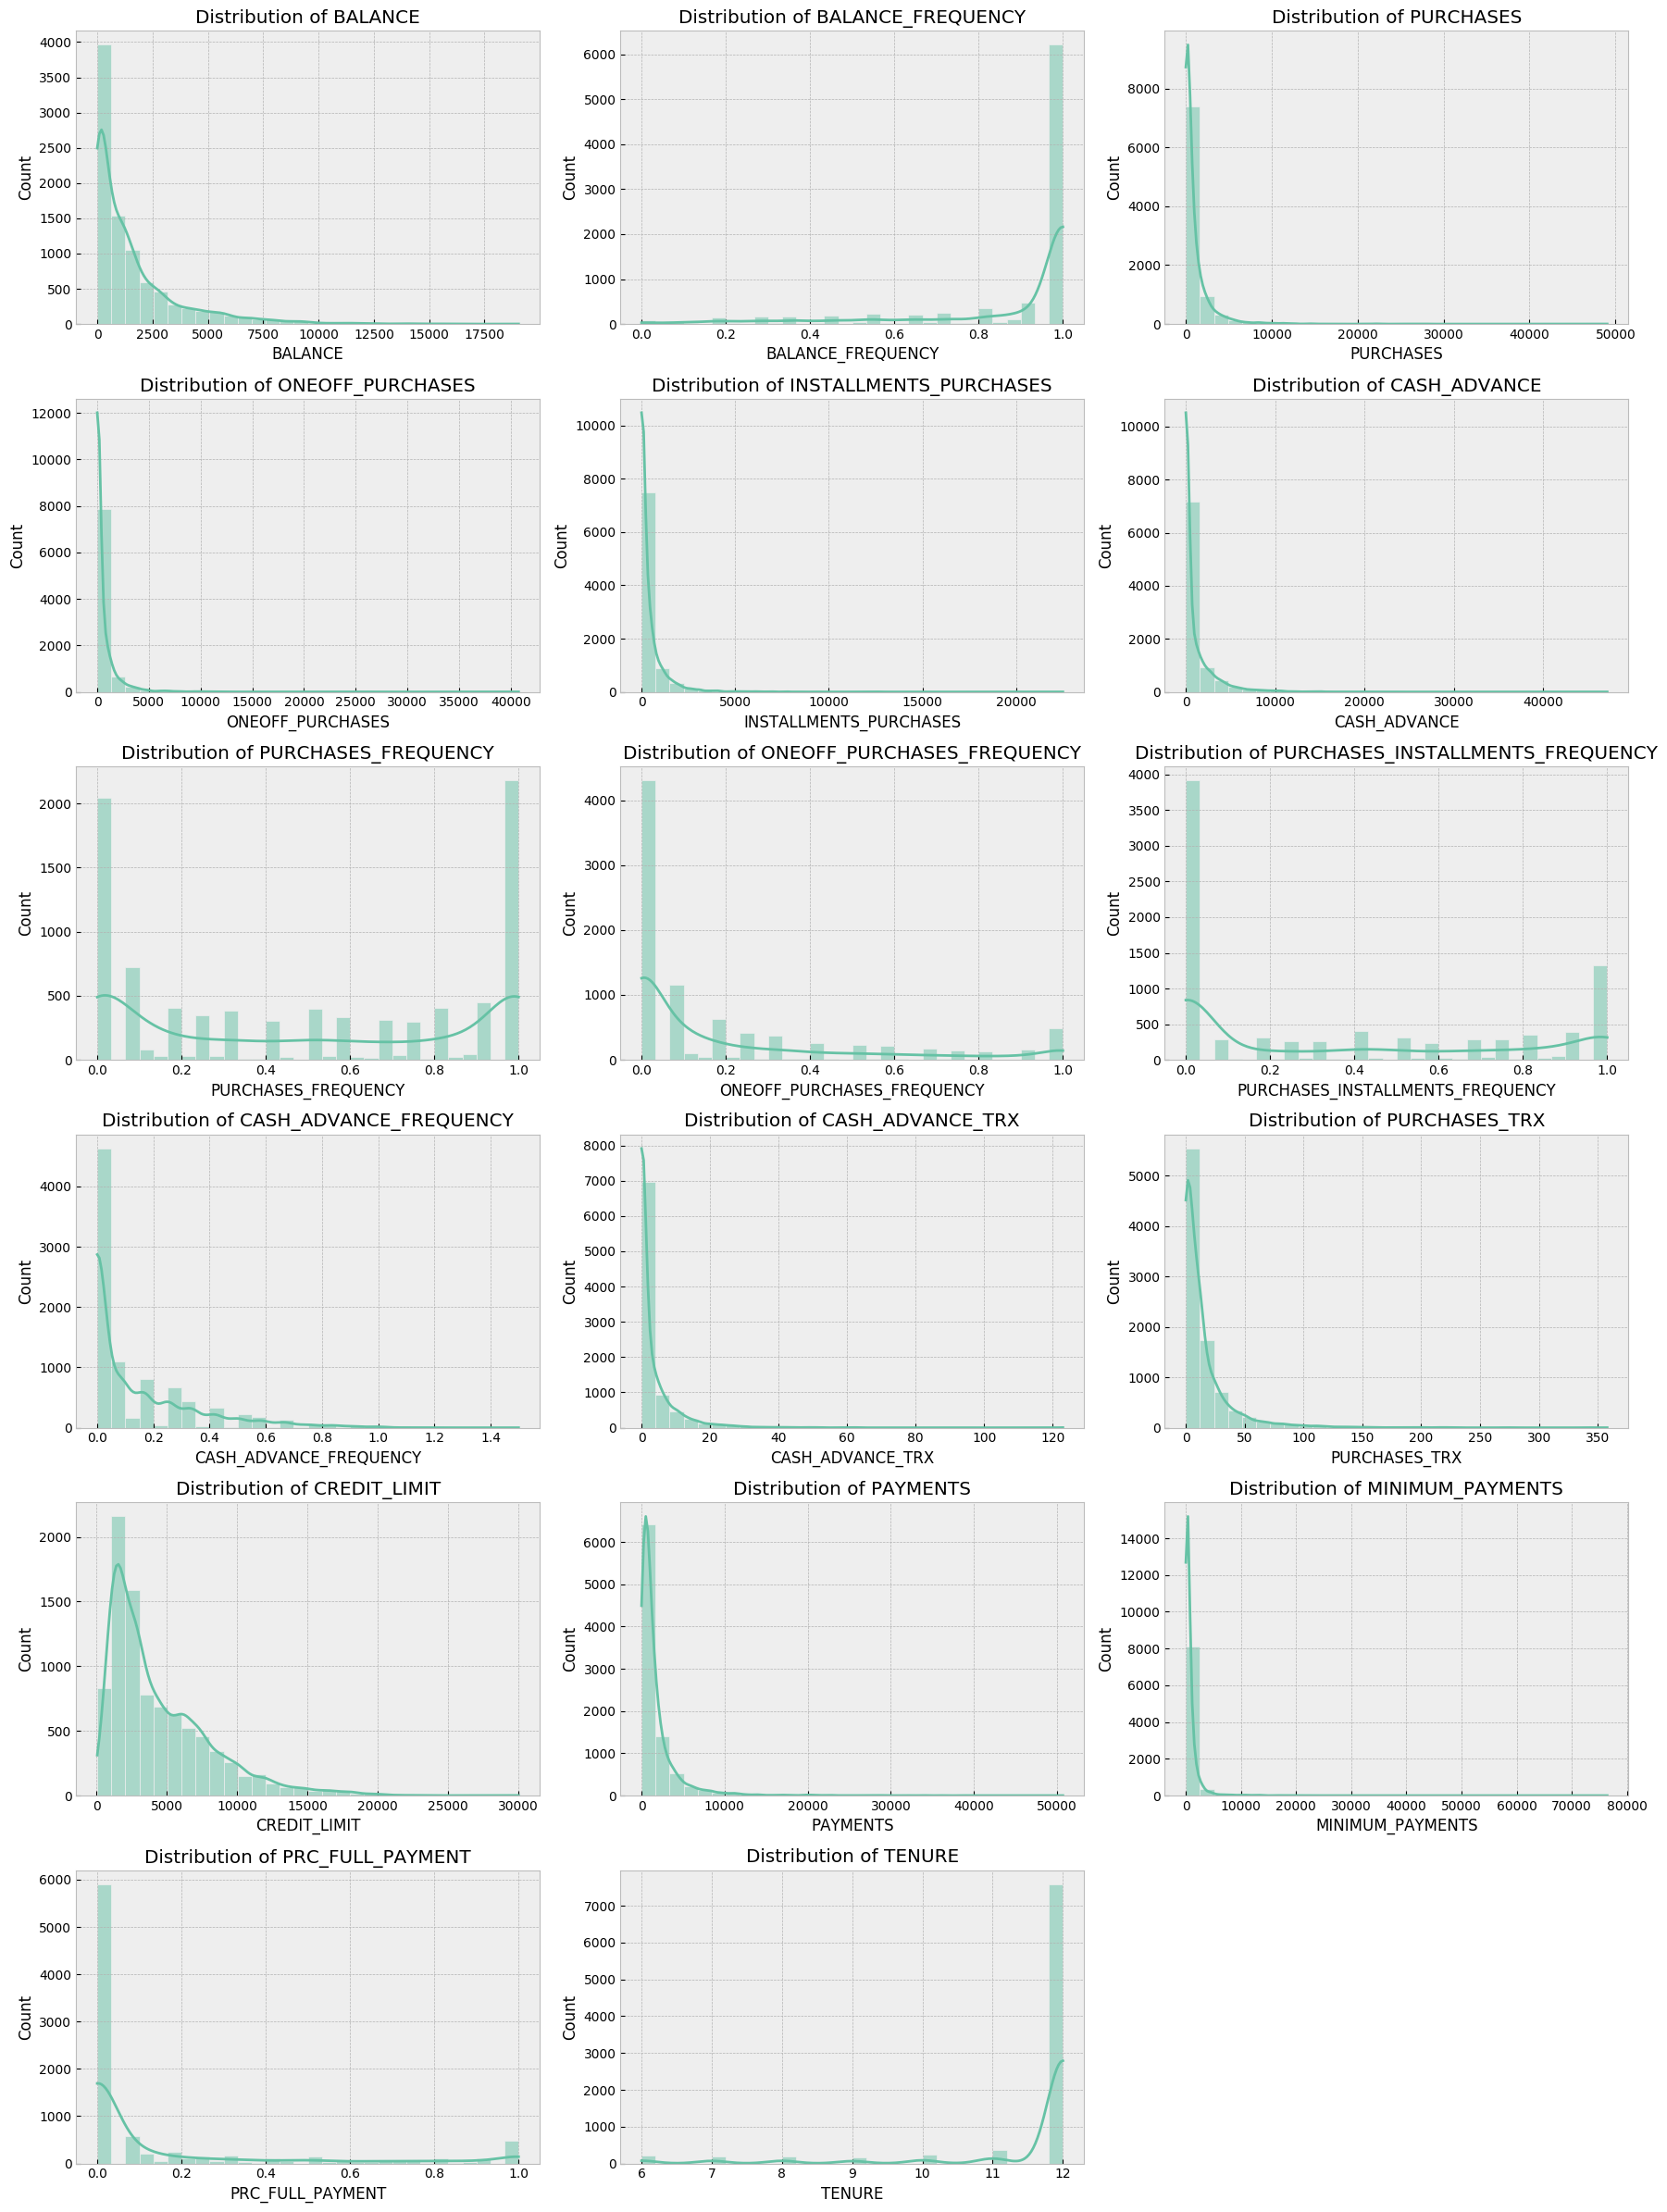

In [48]:
plt.style.use('bmh')
sns.set_palette("Set2")

numerical_cols = df.select_dtypes(include='number').columns

n_cols = len(numerical_cols)
n_rows = (n_cols // 3) + 1

plt.figure(figsize=(18, n_rows * 4))

for idx, col in enumerate(numerical_cols):
    plt.subplot(n_rows, 3, idx + 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Handle Missing Values for Specific Columns

In [49]:
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())

In [50]:
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())

In [51]:
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Correlation Matrix Heatmap
Calculate correlation between numerical variables and visualize it using a heatmap. This reveals relationships between features and helps in feature selection or engineering.

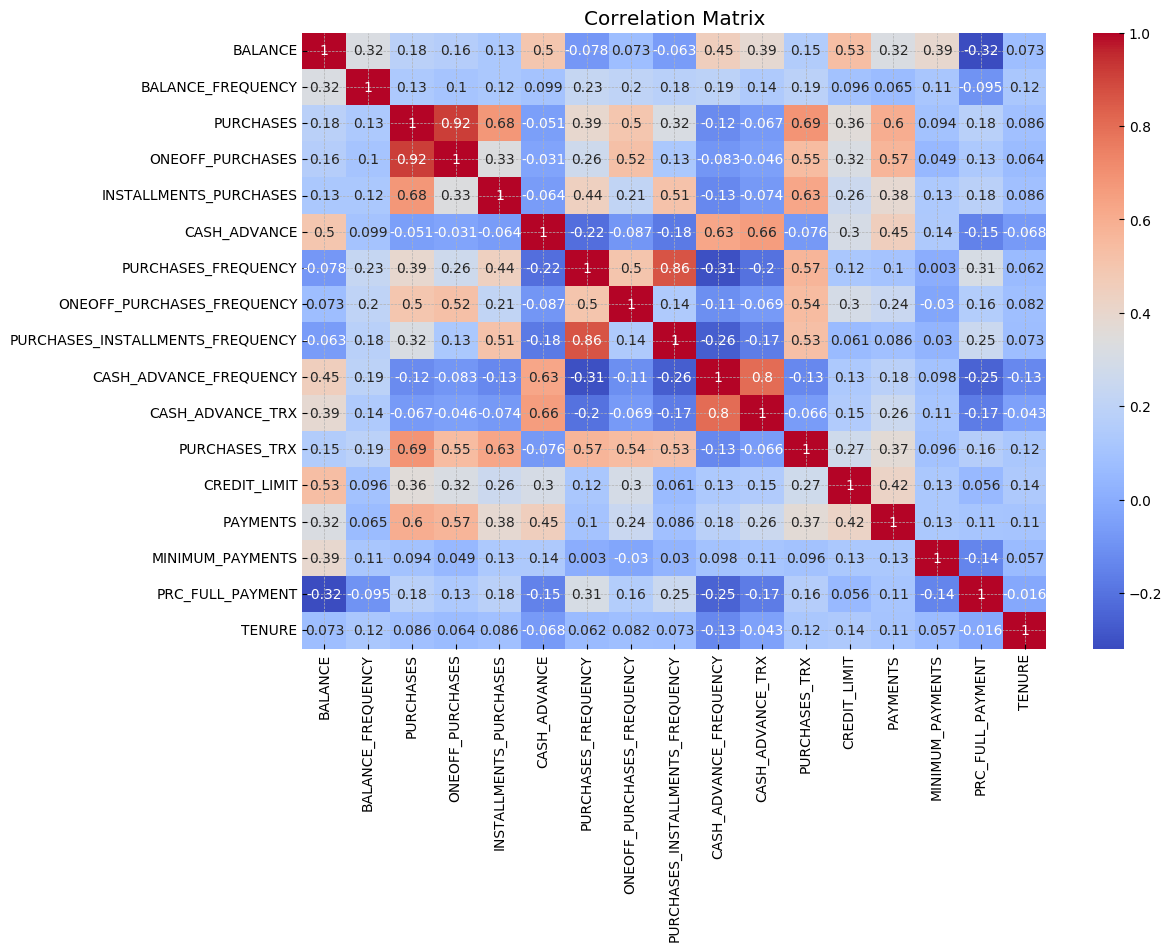

In [53]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Boxplots to Detect Outliers in Numerical Columns
Generate boxplots for each numerical feature to identify outliers and understand data spread.

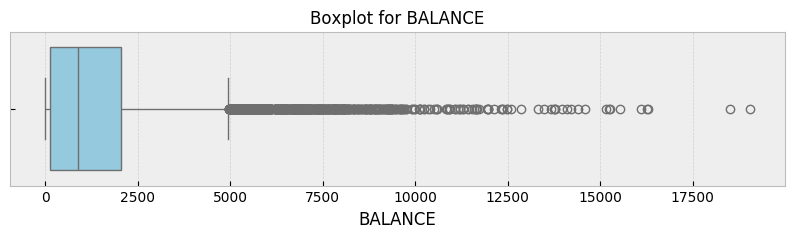

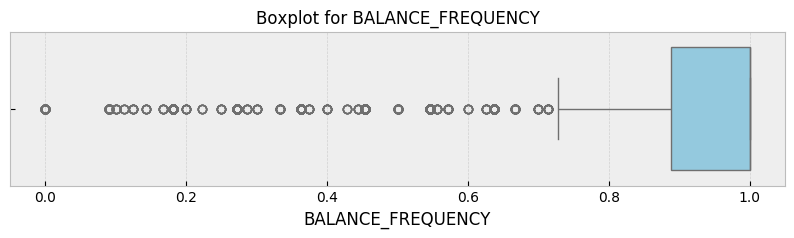

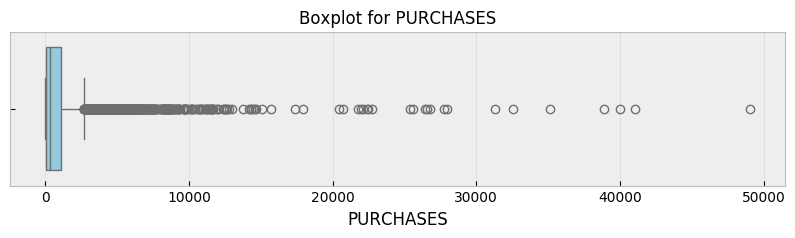

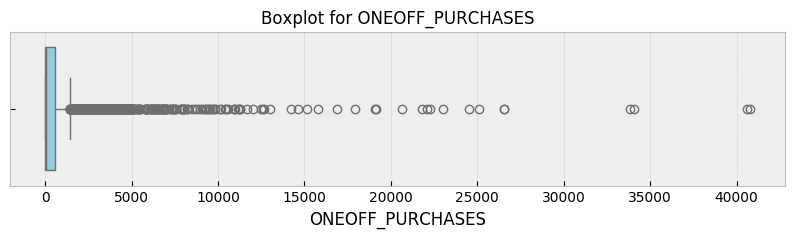

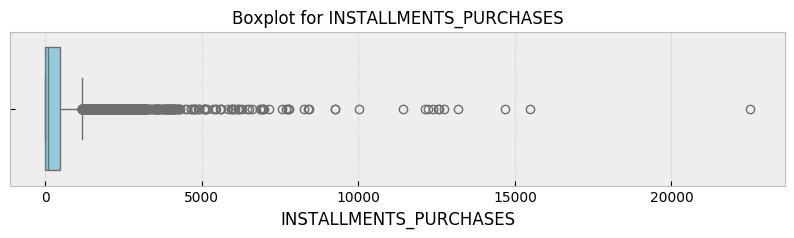

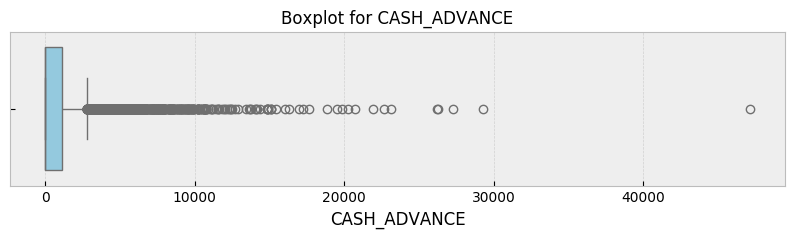

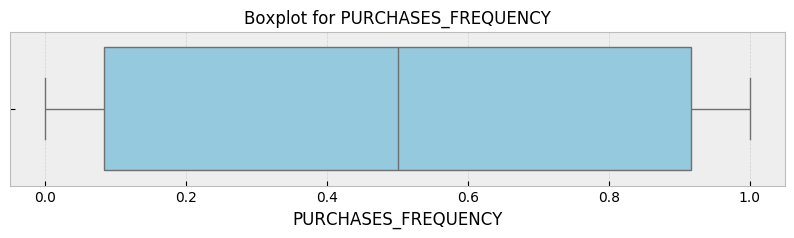

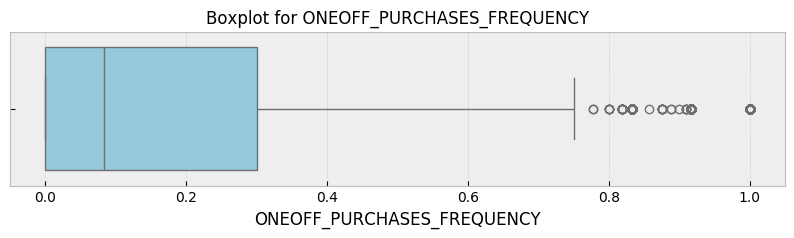

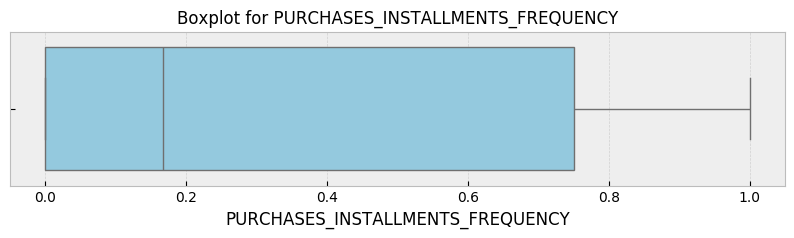

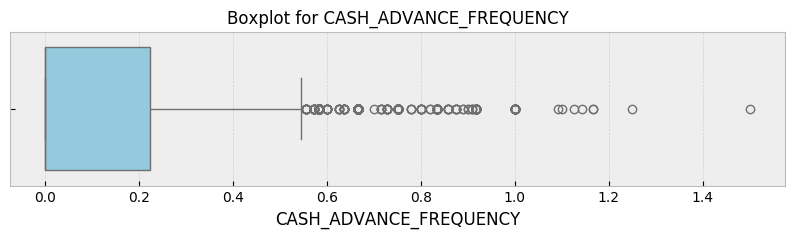

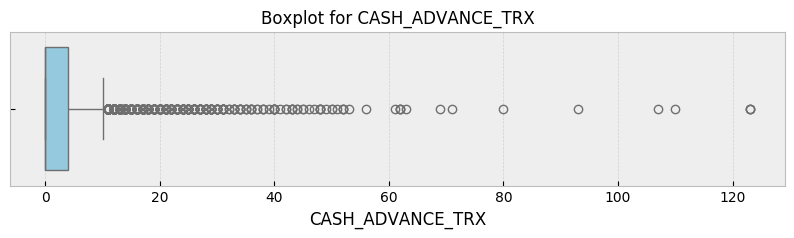

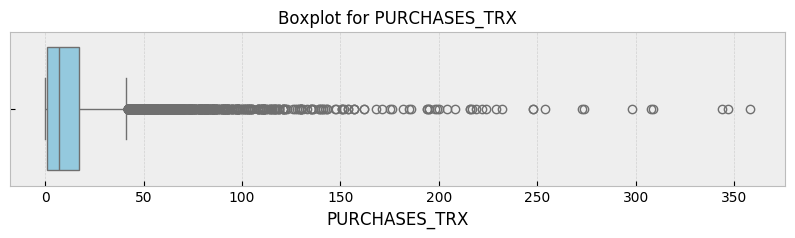

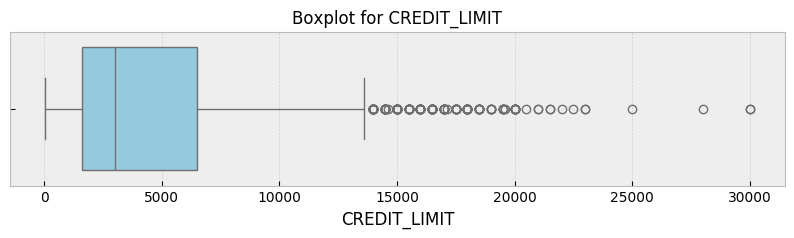

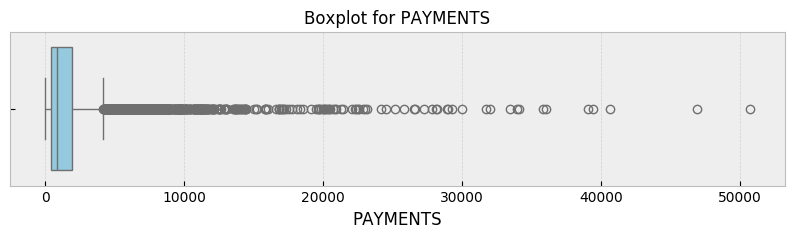

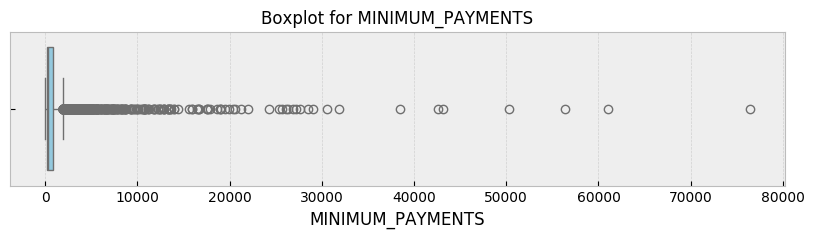

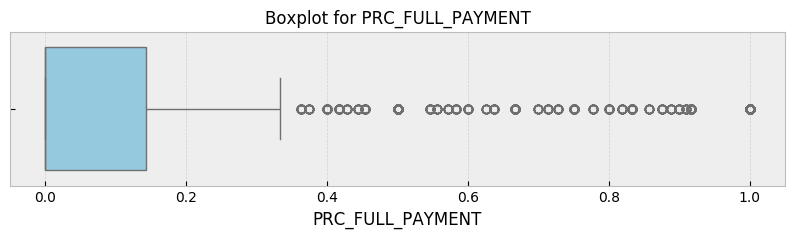

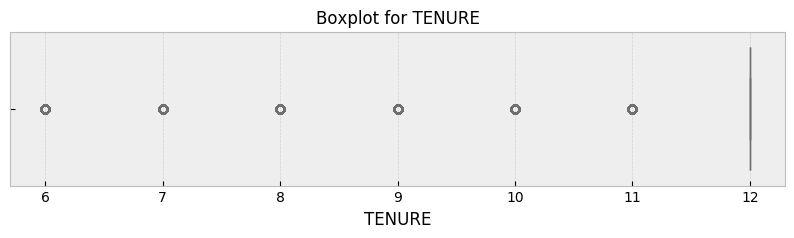

In [54]:
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:

    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot for {col}', fontsize=12)
    plt.xlabel(col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.show()


## Scale Numerical Features using RobustScaler
*   Extract numerical features and apply RobustScaler to reduce the impact of outliers. Store the scaled data back in a DataFrame for further analysis
*   Plot histograms of the scaled features to verify scaling effect and data distribution.



In [88]:
X = df.select_dtypes(include=['float64', 'int64'])
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.432267          -1.636364  -0.248371         -0.065812   
1  1.209374          -0.818182  -0.337489         -0.065812   
2  0.842099           0.000000   0.384766          1.273231   
3  0.411913          -3.272727   1.062798          2.530286   
4 -0.028907           0.000000  -0.322542         -0.038102   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                0.013657      0.000000            -0.399999   
1               -0.189912      5.784542            -0.600000   
2               -0.189912      0.000000             0.600000   
3               -0.189912      0.184759            -0.500000   
4               -0.189912      0.000000            -0.500000   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.277777                         -0.111112   
1                   -0.277777                         -0.222223   
2                    3.055557                         -0.222223   
3                    0.000000                         -0.222223   
4                    0.000000                         -0.222223   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000              0.00        -0.3125     -0.408163   
1                1.125001              1.00        -0.4375      0.816327   
2                0.000000              0.00         0.3125      0.918367   
3                0.374999              0.25        -0.3750      0.918367   
4                0.000000              0.00        -0.3750     -0.367347   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0 -0.431595         -0.282857          0.000000     0.0  
1  2.138626          1.062541          1.555556     0.0  
2 -0.154715          0.420649          0.000000     0.0  
3 -0.564547          0.762355          0.000000     0.0  
4 -0.117644         -0.131012          0.000000     0.0

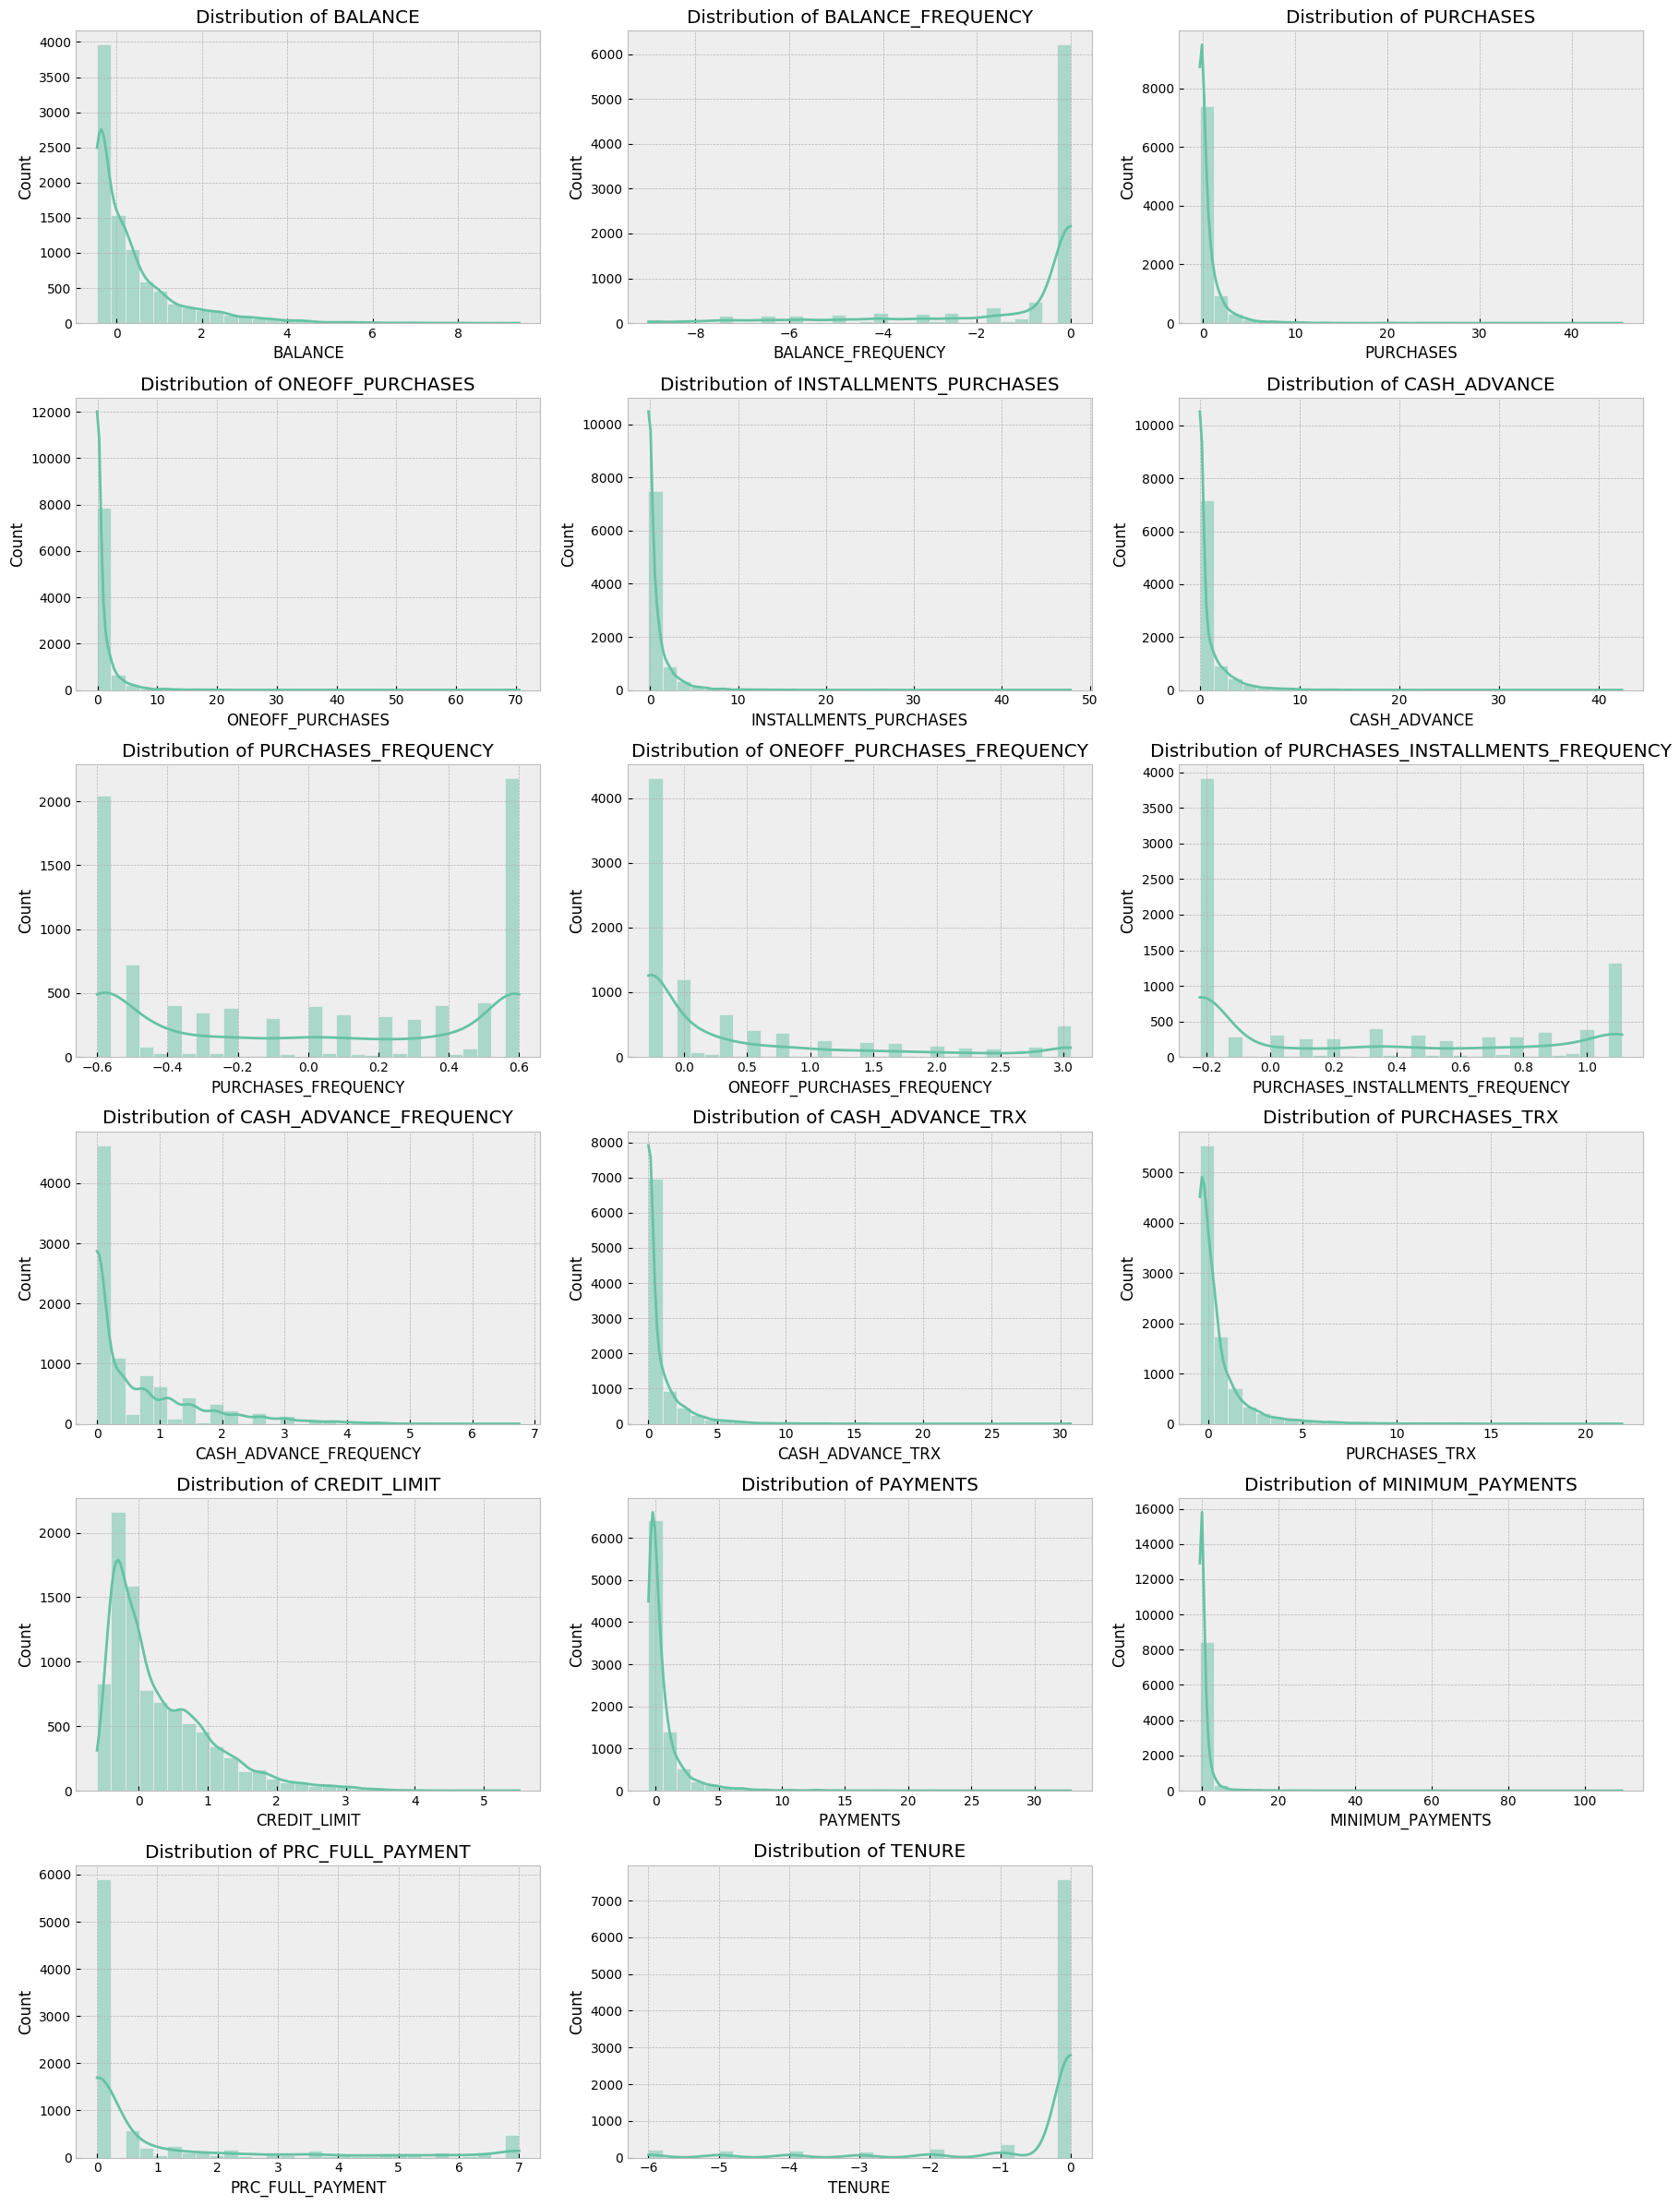

In [90]:
plt.style.use('bmh')
sns.set_palette("Set2")

numerical_cols = X_scaled_df.select_dtypes(include='number').columns

n_cols = 3
n_rows = (len(numerical_cols) // n_cols) + 1

plt.figure(figsize=(18, n_rows * 4))

for idx, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(X_scaled_df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Log Transformation of Numerical Features and Visualization
Apply log transformation (log1p = log(1 + x)) to reduce skewness for features with highly skewed distributions, then plot histograms to see the effect.

In [96]:
X_log = np.log1p(X)
X_scaled_df = pd.DataFrame(X_log, columns=X.columns)
X_scaled_df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  3.735304           0.597837   4.568506          0.000000   
1  8.071989           0.646627   0.000000          0.000000   
2  7.822504           0.693147   6.651791          6.651791   
3  7.419183           0.492477   7.313220          7.313220   
4  6.707735           0.693147   2.833213          2.833213   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                4.568506      0.000000             0.154151   
1                0.000000      8.770896             0.000000   
2                0.000000      0.000000             0.693147   
3                0.000000      5.331694             0.080042   
4                0.000000      0.000000             0.080042   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.080042   
1                    0.000000                          0.000000   
2                    0.693147                          0.000000   
3                    0.080042                          0.000000   
4                    0.080042                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000          0.000000       1.098612      6.908755   
1                0.223144          1.609438       0.000000      8.853808   
2                0.000000          0.000000       2.564949      8.922792   
3                0.080042          0.693147       0.693147      8.922792   
4                0.000000          0.000000       0.693147      7.090910   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0  5.312231          4.945277          0.000000  2.564949  
1  8.319725          6.978531          0.200671  2.564949  
2  6.434654          6.442994          0.000000  2.564949  
3  0.000000          6.762968          0.000000  2.564949  
4  6.521114          5.504483          0.000000  2.564949

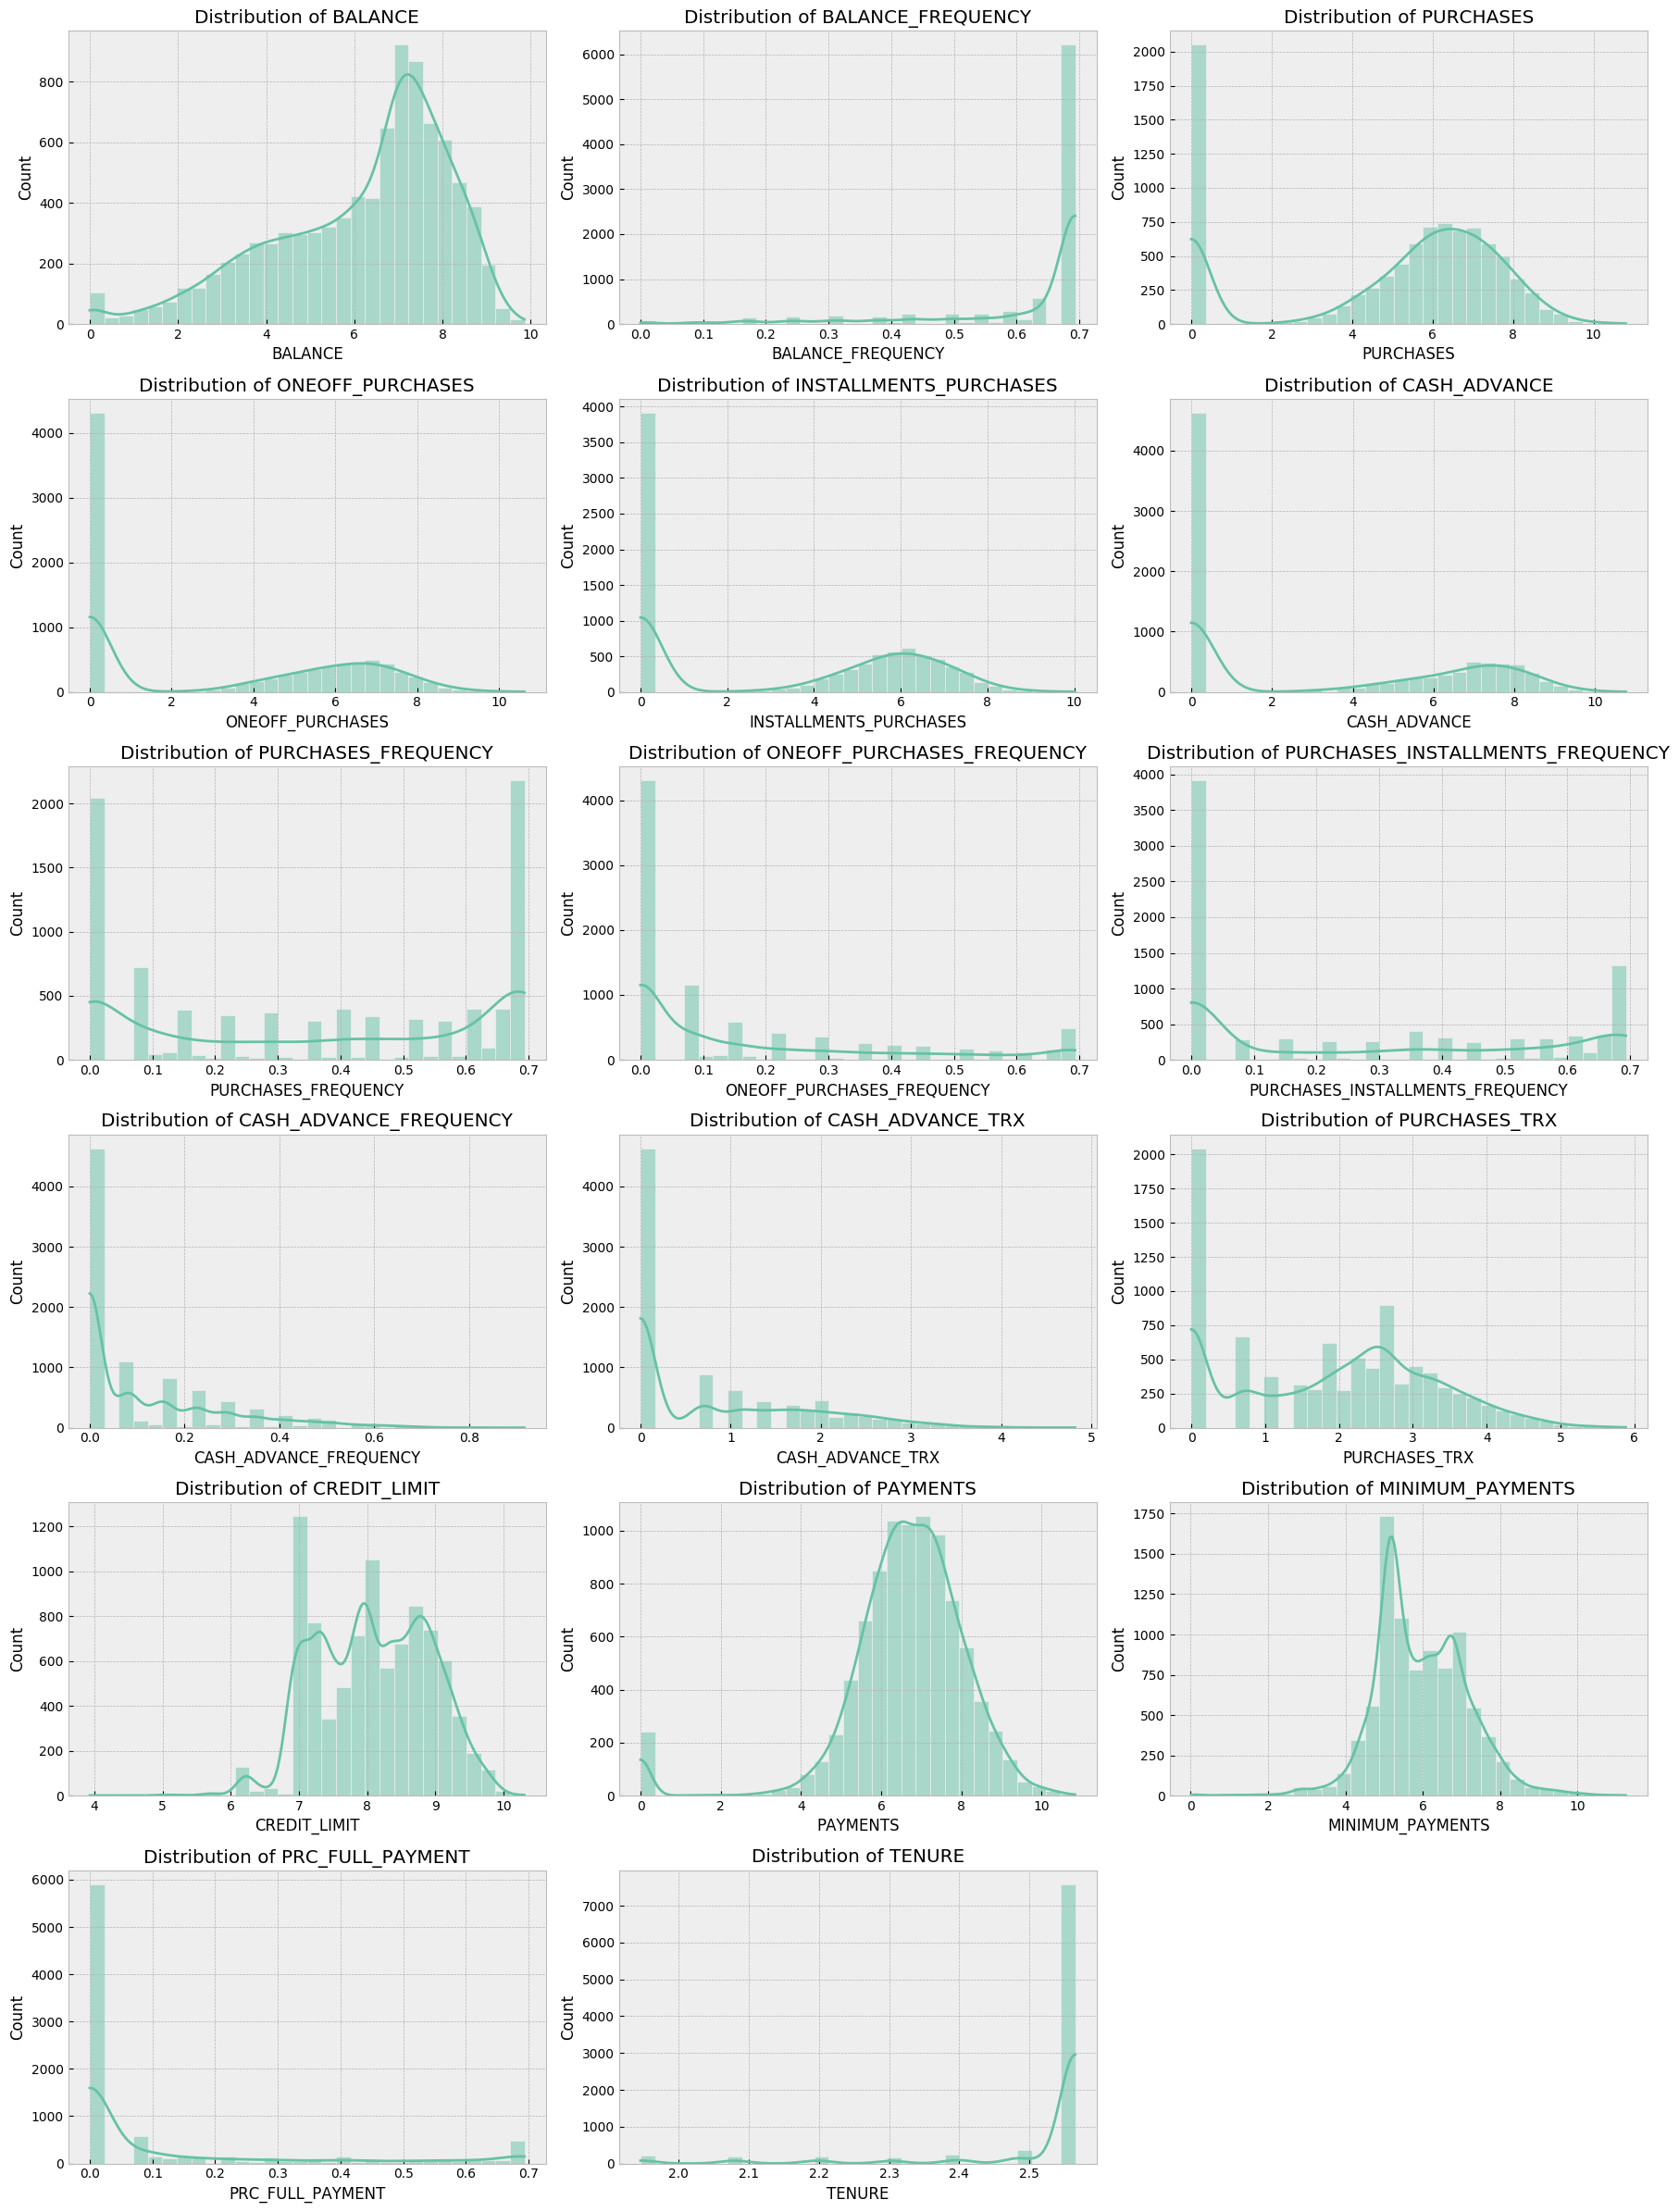

In [97]:
plt.style.use('bmh')
sns.set_palette("Set2")

numerical_cols = X_scaled_df.select_dtypes(include='number').columns

n_cols = len(numerical_cols)
n_rows = (n_cols // 3) + 1

plt.figure(figsize=(18, n_rows * 4))

for idx, col in enumerate(numerical_cols):
    plt.subplot(n_rows, 3, idx + 1)
    sns.histplot(X_scaled_df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Elbow Method to Find Optimal Number of Clusters

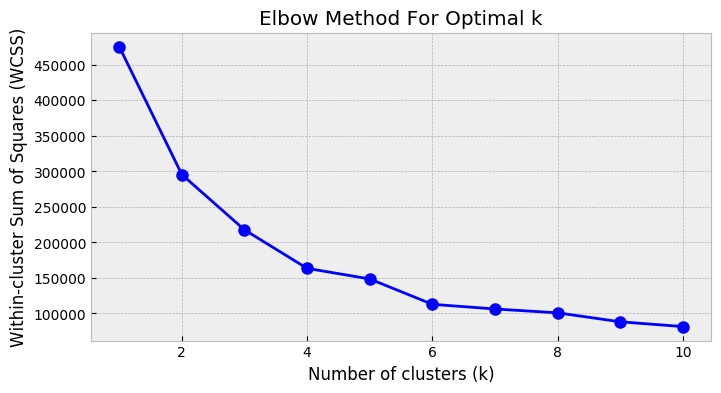

In [98]:
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()


## Silhouette Score to Validate Clustering Quality

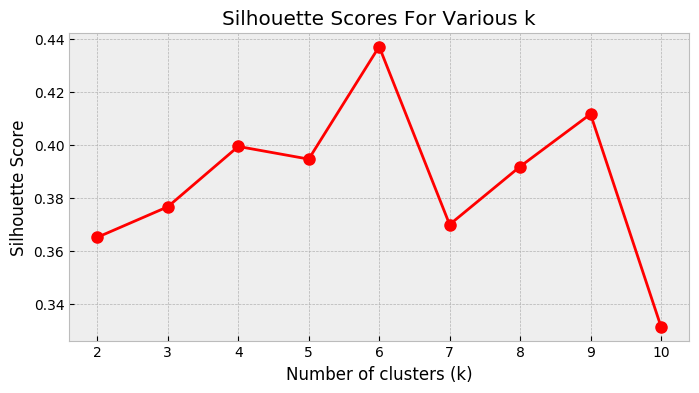

In [99]:
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_df)
    score = silhouette_score(X_scaled_df, labels)
    sil_scores.append(score)

plt.figure(figsize=(8,4))
plt.plot(K, sil_scores, 'ro-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Various k')
plt.show()

## Perform KMeans Clustering with Selected k and Visualize with t-SNE

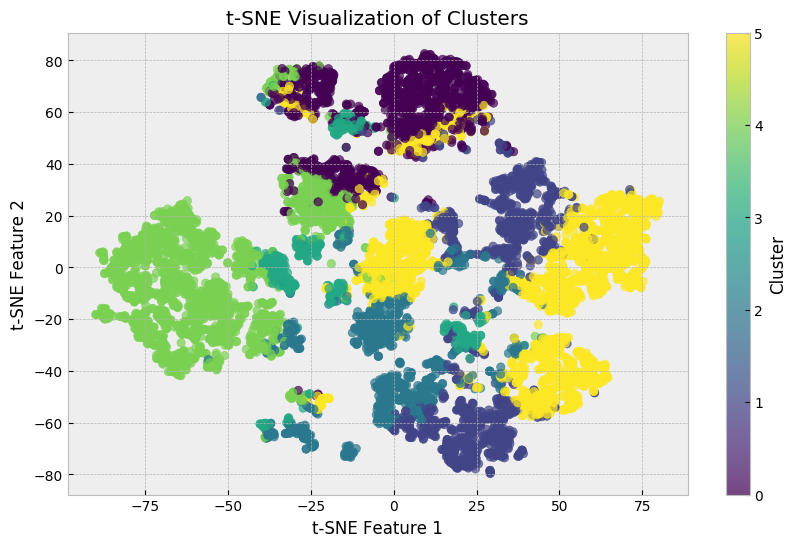

In [111]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.title("t-SNE Visualization of Clusters")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [112]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled_df)

In [113]:
df['Cluster'] = clusters

In [114]:
df

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     C10001    40.900749           0.818182      95.40              0.00   
1     C10002  3202.467416           0.909091       0.00              0.00   
2     C10003  2495.148862           1.000000     773.17            773.17   
3     C10004  1666.670542           0.636364    1499.00           1499.00   
4     C10005   817.714335           1.000000      16.00             16.00   
...      ...          ...                ...        ...               ...   
8945  C19186    28.493517           1.000000     291.12              0.00   
8946  C19187    19.183215           1.000000     300.00              0.00   
8947  C19188    23.398673           0.833333     144.40              0.00   
8948  C19189    13.457564           0.833333       0.00              0.00   
8949  C19190   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.945483             0.000000   
2                       0.00      0.000000             1.000000   
3                       0.00    205.788017             0.083333   
4                       0.00      0.000000             0.083333   
...                      ...           ...                  ...   
8945                  291.12      0.000000             1.000000   
8946                  300.00      0.000000             1.000000   
8947                  144.40      0.000000             0.833333   
8948                    0.00     36.558778             0.000000   
8949                    0.00    127.040008             0.666667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.083333   
1                       0.000000                          0.000000   
2                       1.000000                          0.000000   
3                       0.083333                          0.000000   
4                       0.083333                          0.000000   
...                          ...                               ...   
8945                    0.000000                          0.833333   
8946                    0.000000                          0.833333   
8947                    0.000000                          0.666667   
8948                    0.000000                          0.000000   
8949                    0.666667                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1000.0   
1                   0.250000                 4              0        7000.0   
2                   0.000000                 0             12        7500.0   
3                   0.083333                 1              1        7500.0   
4                   0.000000                 0              1        1200.0   
...                      ...               ...            ...           ...   
8945                0.000000                 0              6        1000.0   
8946                0.000000                 0              6        1000.0   
8947                0.000000                 0              5        1000.0   
8948                0.166667                 2              0         500.0   
8949                0.333333                 2             23        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  Cluster  
0      201.802084        139.509787          0.000000      12        2  
1     4103.032597       1072.340217          0.222222      12        1  
2      622.066742        627.284787          0.000000      12        3  
3        0.000000        864.206542          0.000000      12        0  
4      678.334763        244.791237          0.000000      12        3  
...           ...               ...            

## Apply KMeans Clustering and Assign Cluster Labels to Dataset

In [117]:
df['Cluster'] = kmeans.labels_

numeric_cols = df.select_dtypes(include=['number']).columns

cluster_profiles = df[numeric_cols].groupby(df['Cluster']).mean()
display(cluster_profiles)


BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        2387.474663           0.930583   674.244370        674.310051   
1        2153.423559           0.883008     0.538800          0.067571   
2         397.531185           0.787894   523.155934          1.762644   
3         755.959742           0.771646   863.911847        863.058912   
4        2872.743484           0.968511  1551.990982        825.030762   
5        1261.059921           0.944240  2604.567809       1600.801743   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                      0.345206   2071.099580             0.280809   
1                      0.512812   1999.641369             0.003764   
2                    522.338667      3.570185             0.700330   
3                      0.936726      0.813881             0.356031   
4                    727.195565   2169.599973             0.753010   
5                   1003.795319      0.731839             0.830297   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                          0.279072                          0.002295   
1                          0.001203                          0.002413   
2                          0.004844                          0.664255   
3                          0.352877                          0.004233   
4                          0.281790                          0.632883   
5                          0.479475                          0.663196   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
Cluster                                                            
0                      0.299450          6.989717       6.365039   
1                      0.272362          6.341463       0.043520   
2                      0.003186          0.038522      11.687142   
3                      0.001699          0.020517       7.732382   
4                      0.291138          7.521994      25.530059   
5                      0.001149          0.013134      36.219701   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
Cluster                                                                  
0         4642.833606  1950.064238       1040.567909          0.053396   
1         4037.379778  1668.927799       1003.114407          0.043737   
2         3112.588956   735.879669        710.097360          0.298983   
3         4411.606250  1181.122656        511.611998          0.137875   
4         5498.028674  2760.371179       1340.149085          0.059375   
5         5819.123474  2389.223786        634.028098          0.258422   

            TENURE  Cluster  
Cluster                      
0        11.313625      0.0  
1        11.324247      1.0  
2        11.494534      2.0  
3        11.555754      3.0  
4        11.550587      4.0  
5        11.826269      5.0

## Cluster Descriptions

| Cluster | Customer Profile                        | Key Traits                                                               |
| ------- | --------------------------------------- | ------------------------------------------------------------------------ |
| 0       | One-off buyers with frequent cash usage | High one-time purchases + frequent cash advances                         |
| 1       | Cash-dependent non-shoppers             | Very low purchases, use credit card mainly for cash                      |
| 2       | Installment-heavy customers             | Moderate total spend, prefer installments, buy regularly                 |
| 3       | Heavy one-off spenders                  | High one-off purchases, low cash, few transactions                       |
| 4       | All-round high spenders                 | High spending across all types, frequent usage, moderately high cash use |
| 5       | Super loyal and high-value customers    | Highest spenders, very frequent buyers, balanced usage                   |


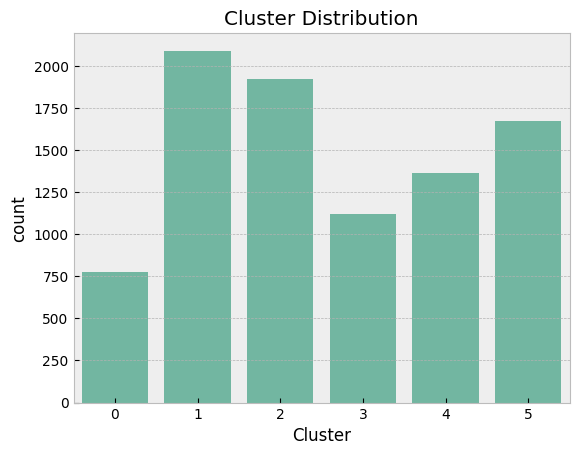

In [118]:
sns.countplot(x='Cluster', data=df)
plt.title('Cluster Distribution')
plt.show()

## Apply PCA for Dimensionality Reduction and Visualize Clusters in 2D Space

<Axes: xlabel='PCA1', ylabel='PCA2'>

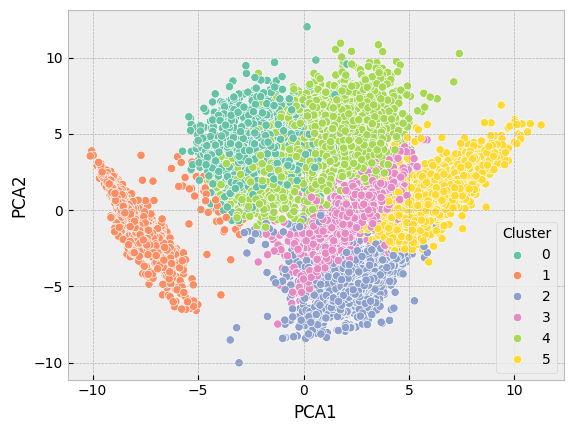

In [120]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled_df)
df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')

## Fit GMM and Predict Cluster Labels

In [136]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled_df)

df['Cluster_GMM'] = gmm_labels

In [137]:
cluster_profiles_gmm = df.groupby('Cluster_GMM')[numeric_cols].mean()
display(cluster_profiles_gmm)

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster_GMM                                                                  
0            2334.699372           0.924710   659.004714        659.004714   
1            2150.187407           0.882479     0.000000          0.000000   
2             397.795977           0.788326   535.374818          0.000000   
3             762.608963           0.769453   883.035435        883.035435   
4            2751.740460           0.964902  1496.724649        797.688662   
5            1210.433819           0.931495  2448.807552       1496.851656   

             INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster_GMM                                                              
0                          0.000000   2028.200508             0.275094   
1                          0.000000   1991.030938             0.000000   
2                        535.374818      0.000000             0.705972   
3                          0.000000      0.000000             0.355049   
4                        699.933034   2074.669707             0.737924   
5                        952.724127      0.000000             0.809951   

             ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster_GMM                                                                 
0                              0.275094                          0.000000   
1                              0.000000                          0.000000   
2                              0.000000                          0.672467   
3                              0.355049                          0.000000   
4                              0.272200                          0.620674   
5                              0.456991                          0.644473   

             CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
Cluster_GMM                                                            
0                          0.292492          6.829602       6.273632   
1                          0.272965          6.303580       0.000000   
2                          0.000000          0.000000      11.747345   
3                          0.000000          0.000000       7.733396   
4                          0.282297          7.252027      24.788514   
5                          0.000000          0.000000      34.278689   

             CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
Cluster_GMM                                                                  
0             4631.373813  1912.065682       1020.437897          0.058157   
1             4028.965726  1655.461452       1000.085042          0.044269   
2             3109.789482   730.790342        726.576445          0.305880   
3             4429.757349  1202.369739        519.814067          0.136120   
4             5355.615616  2684.092388       1304.416120          0.062685   
5             5687.677681  2280.201729        615.591142          0.256200   

                TENURE   Cluster  
Cluster_GMM                       
0            11.351990  0.095771  
1            11.317312  1.000000  
2            11.511459  1.999441  
3            11.556595  2.997194  
4            11.525000  3.850676  
5            11.798756  4.822499

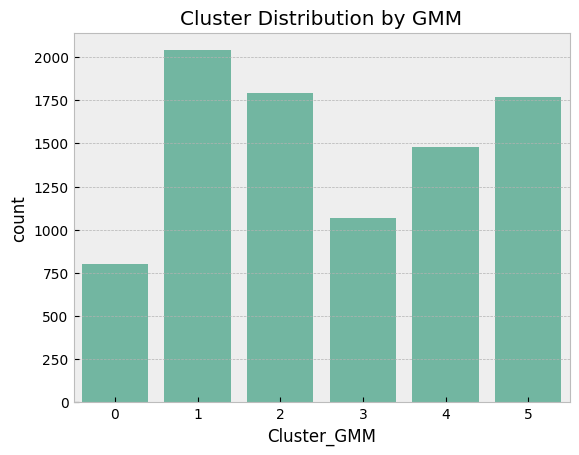

In [138]:
sns.countplot(x='Cluster_GMM', data=df)
plt.title('Cluster Distribution by GMM')
plt.show()

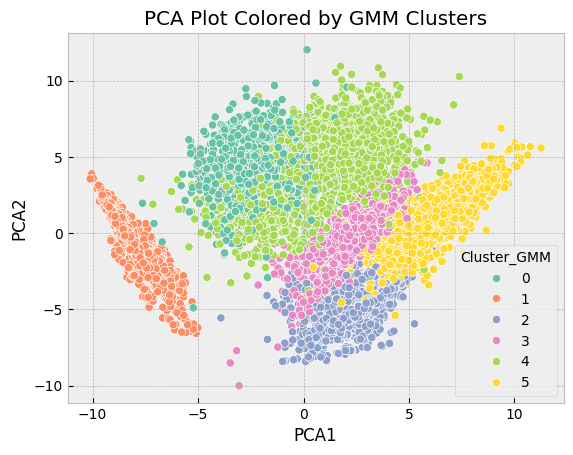

In [139]:
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_GMM', palette='Set2')
plt.title('PCA Plot Colored by GMM Clusters')
plt.show()


## Compare with KMeans clusters visually

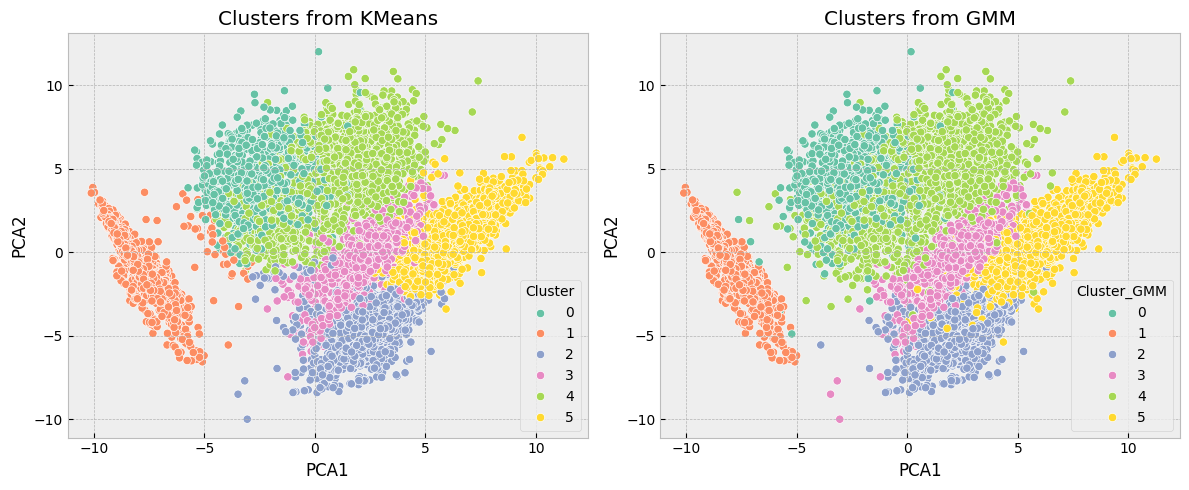

In [140]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Clusters from KMeans')

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_GMM', palette='Set2')
plt.title('Clusters from GMM')

plt.tight_layout()
plt.show()

we can see the GMM is better fitting than Kmeans ,so you use it

## Visualizations + Business Insights

In [141]:
cluster_profiles_gmm = df.groupby('Cluster_GMM')[numeric_cols].mean()
cluster_profiles_gmm['Count'] = df['Cluster_GMM'].value_counts().sort_index()
display(cluster_profiles_gmm)

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster_GMM                                                                  
0            2334.699372           0.924710   659.004714        659.004714   
1            2150.187407           0.882479     0.000000          0.000000   
2             397.795977           0.788326   535.374818          0.000000   
3             762.608963           0.769453   883.035435        883.035435   
4            2751.740460           0.964902  1496.724649        797.688662   
5            1210.433819           0.931495  2448.807552       1496.851656   

             INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster_GMM                                                              
0                          0.000000   2028.200508             0.275094   
1                          0.000000   1991.030938             0.000000   
2                        535.374818      0.000000             0.705972   
3                          0.000000      0.000000             0.355049   
4                        699.933034   2074.669707             0.737924   
5                        952.724127      0.000000             0.809951   

             ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster_GMM                                                                 
0                              0.275094                          0.000000   
1                              0.000000                          0.000000   
2                              0.000000                          0.672467   
3                              0.355049                          0.000000   
4                              0.272200                          0.620674   
5                              0.456991                          0.644473   

             CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
Cluster_GMM                                                            
0                          0.292492          6.829602       6.273632   
1                          0.272965          6.303580       0.000000   
2                          0.000000          0.000000      11.747345   
3                          0.000000          0.000000       7.733396   
4                          0.282297          7.252027      24.788514   
5                          0.000000          0.000000      34.278689   

             CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
Cluster_GMM                                                                  
0             4631.373813  1912.065682       1020.437897          0.058157   
1             4028.965726  1655.461452       1000.085042          0.044269   
2             3109.789482   730.790342        726.576445          0.305880   
3             4429.757349  1202.369739        519.814067          0.136120   
4             5355.615616  2684.092388       1304.416120          0.062685   
5             5687.677681  2280.201729        615.591142          0.256200   

                TENURE   Cluster  Count  
Cluster_GMM                              
0            11.351990  0.095771    804  
1            11.317312  1.000000   2039  
2            11.511459  1.999441   1789  
3            11.556595  2.997194   1069  
4            11.525000  3.850676   1480  
5            11.798756  4.822499   1769

<ipython-input-121-d8cb63e110cf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profiles.index, y=cluster_profiles['BALANCE'], palette='Blues_d')


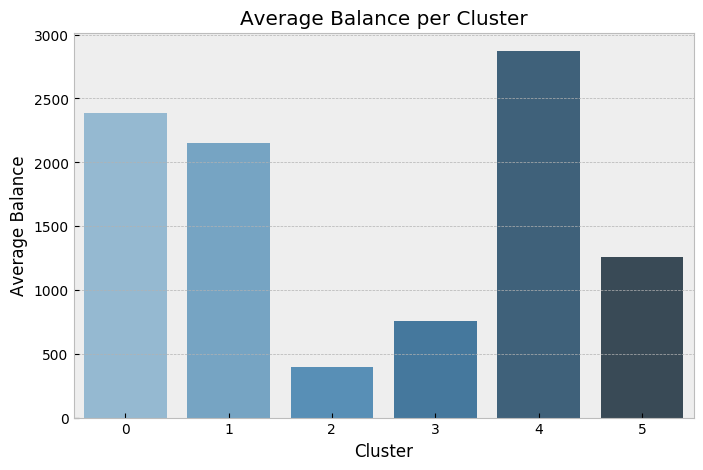

In [121]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_profiles.index, y=cluster_profiles['BALANCE'], palette='Blues_d')
plt.title('Average Balance per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Balance')
plt.show()

<ipython-input-143-265dbcce9186>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profiles_gmm.index, y=cluster_profiles_gmm['BALANCE'], palette='Blues_d')


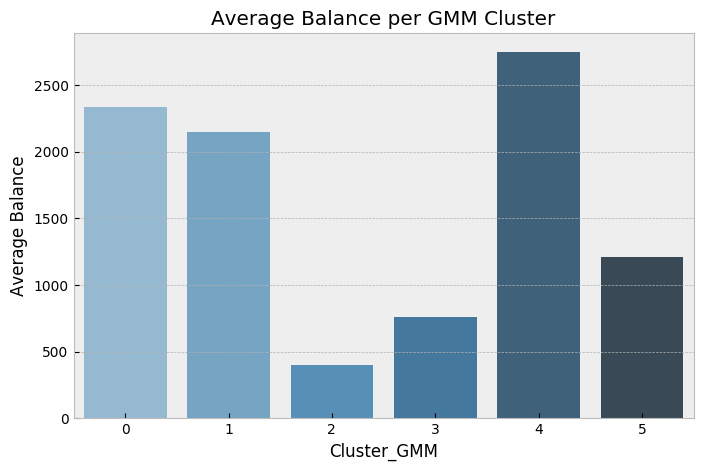

In [143]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_profiles_gmm.index, y=cluster_profiles_gmm['BALANCE'], palette='Blues_d')
plt.title('Average Balance per GMM Cluster')
plt.xlabel('Cluster_GMM')
plt.ylabel('Average Balance')
plt.show()

🔍 Insight:

Cluster 4 has the highest average balance, suggesting they are high-value customers with large credit usage.

Cluster 2 has the lowest, which could imply either low-income users or inactive accounts.

<ipython-input-144-b169a62e62ec>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profiles_gmm.index, y=cluster_profiles_gmm['PURCHASES'], palette='Greens')


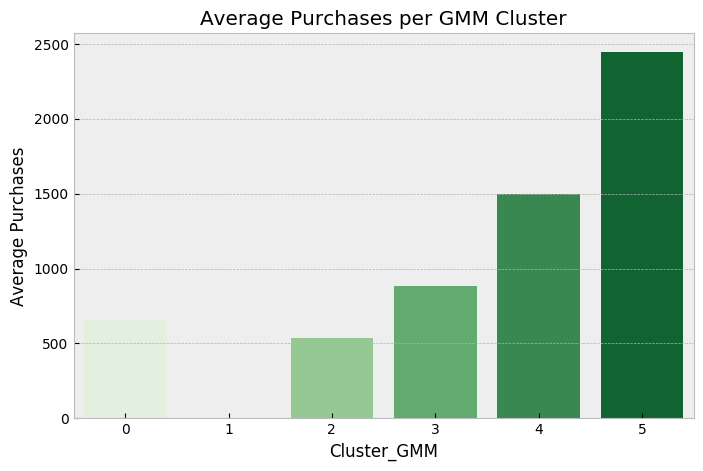

In [144]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_profiles_gmm.index, y=cluster_profiles_gmm['PURCHASES'], palette='Greens')
plt.title('Average Purchases per GMM Cluster')
plt.xlabel('Cluster_GMM')
plt.ylabel('Average Purchases')
plt.show()

🔍 Insight:

Cluster 5 is the top spender, making them prime targets for premium offers and loyalty programs.

Cluster 0 ,1 makes almost no purchases, indicating low engagement with the product.

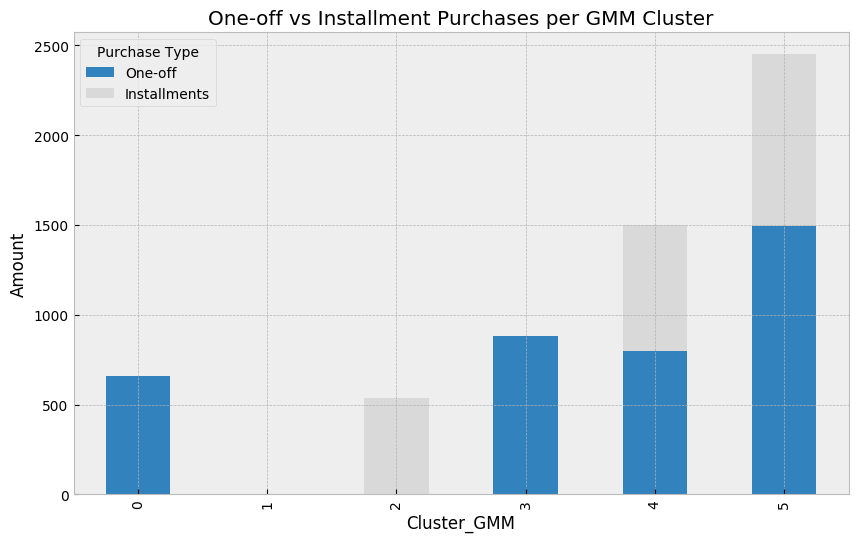

In [145]:
oneoff = cluster_profiles_gmm['ONEOFF_PURCHASES']
installments = cluster_profiles_gmm['INSTALLMENTS_PURCHASES']

df_stacked = pd.DataFrame({'One-off': oneoff, 'Installments': installments}, index=cluster_profiles_gmm.index)

df_stacked.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20c')
plt.title('One-off vs Installment Purchases per GMM Cluster')
plt.xlabel('Cluster_GMM')
plt.ylabel('Amount')
plt.legend(title='Purchase Type')
plt.show()

🔍 Insight:

Cluster 5 again leads, showing a strong preference for one-time, large-value purchases — ideal for flash deals and exclusive events.

Cluster 2 and 1 make very few one-off purchases, highlighting low purchasing activity.

<ipython-input-146-951354af84e9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profiles_gmm.index, y=cluster_profiles_gmm['CASH_ADVANCE'], palette='Oranges')


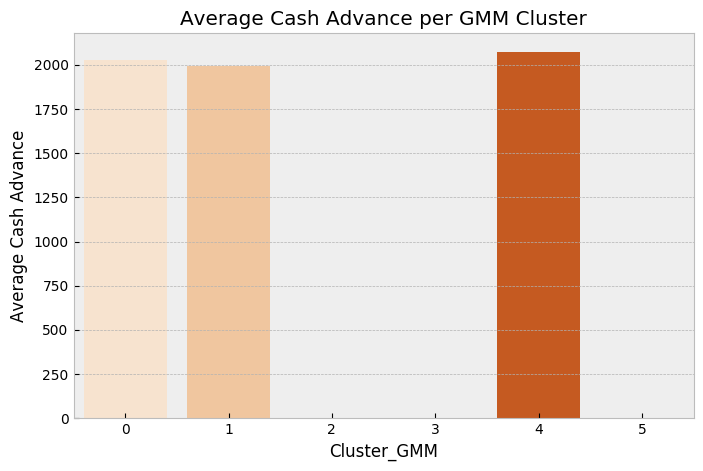

In [146]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_profiles_gmm.index, y=cluster_profiles_gmm['CASH_ADVANCE'], palette='Oranges')
plt.title('Average Cash Advance per GMM Cluster')
plt.xlabel('Cluster_GMM')
plt.ylabel('Average Cash Advance')
plt.show()


🔍 Insight:

Clusters 0, 1, and 4 rely heavily on cash advances — possibly due to liquidity issues or emergencies. Risk assessment teams should monitor them closely.

Clusters 2, 3, and 5 use this feature very little or not at all.

<ipython-input-126-8dd89db7fb48>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profiles.index, y=cluster_profiles['PURCHASES_TRX'], palette='Purples')


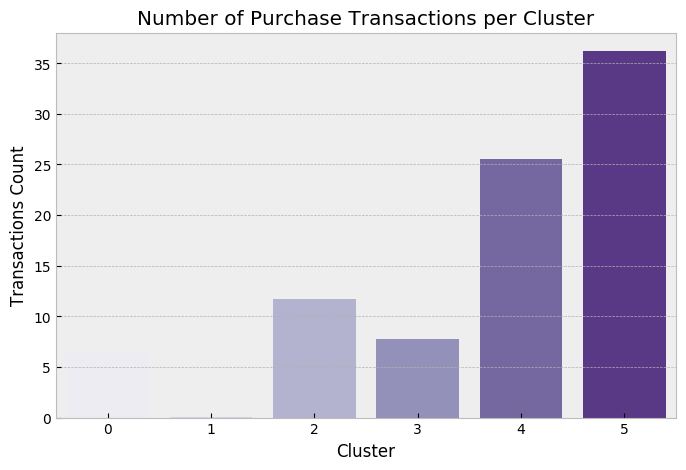

In [126]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_profiles.index, y=cluster_profiles['PURCHASES_TRX'], palette='Purples')
plt.title('Number of Purchase Transactions per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Transactions Count')
plt.show()


🔍 Insight:

Cluster 5 performs the most transactions, showing frequent card use — ideal for cashback rewards.

Cluster 1 barely transacts, indicating disengagement or dormant accounts.

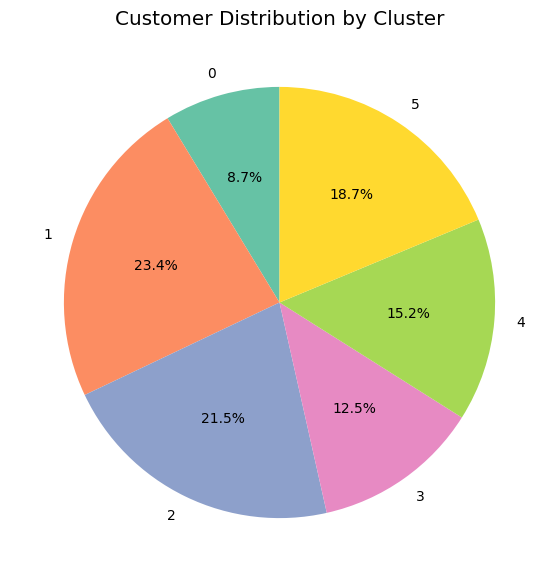

In [128]:
cluster_profiles['Count'] = df['Cluster'].value_counts().sort_index()
plt.figure(figsize=(7, 7))
cluster_profiles['Count'].plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Customer Distribution by Cluster')
plt.ylabel('')
plt.show()

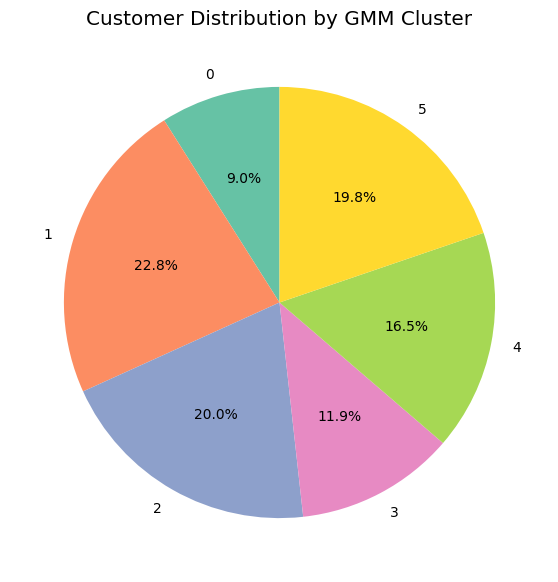

In [147]:
plt.figure(figsize=(7, 7))
cluster_profiles_gmm['Count'].plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Customer Distribution by GMM Cluster')
plt.ylabel('')
plt.show()

🔍 Insight:
The business should focus marketing and retention strategies primarily on Cluster 1, Cluster 2, and Cluster 5, as they represent over two-thirds of the customer base. Meanwhile, Cluster 0 may require specialized attention to either grow it or understand its distinct behavior.

<ipython-input-130-ee3749fbc612>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


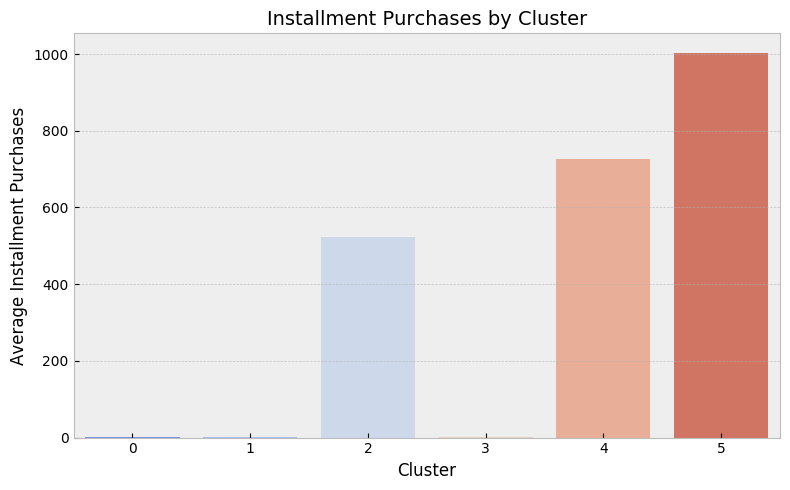

In [130]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_profiles.index,
    y=cluster_profiles['INSTALLMENTS_PURCHASES'],
    palette='coolwarm'
)
plt.title('Installment Purchases by Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Average Installment Purchases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

🔍 Insight:

Cluster 5 also prefers installment options significantly, making them good candidates for long-term financing programs.

Clusters 0 ,1, 3 show very limited use of installment plans.

# Save data for cluster profiles

In [133]:
cluster_profiles.to_csv('cluster_profiles.csv', index=False)

In [149]:
cluster_profiles_gmm.to_csv('cluster_profiles_gmm.csv', index=False)